# **Классификация видеороликов**
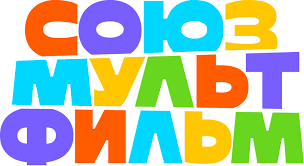

**Заказчик**
Компания Союзмультфильм. Основной вид деятельности Студии Союзмультфильм –
производство контента, анимационных фильмов.
Описание проекта
Студия для оценки популярности проектов мониторит рынок и собирает статистику. И
очень важно агрегировать статистику именно по проектам, а не отдельным роликам.

Необходимо создать автоматизированное решение по определению принадлежности
ролика к тому или иному проекту на основе анализа текстового описания видеороликов
и другой доступной информации.
Задача осложняется тем что тексты могут быть на разных языках. В текстах могут быть
ошибки, опечатки, замена знаков lat/cyr, может отсутствовать описание.
Ролики одного проекта могут быть размещены на разных каналах.
Для решения задачи можно использовать датасет, а также обращаться к youtube для
получения дополнительной информации, например субтитры, tags, thumbnails
К сожалению, не для всех роликов возможно обогащение данных – например, лайвы,
прямые эфиры недоступны после завершения. Также есть закрытые каналы, то есть
никакая информация оттуда недоступна.
 
**Цель**

Предложить решение для категоризации роликов по проектам.
1. Максимизировать метрику f1
2. Создать модуль (класс, функцию) для определения проекта:
- на вход подается список уникальных идентификаторов yt_reel_id
(опционально распознавать список или одиночный идентификатор)
- на выходе список словарей
{‘yt_reel_id’: идентификатор, ‘cartoon’: название_проекта_или_none}
- для роликов, которые не входят ни в один проект, в поле cartoon должна возвращаться строка ‘none’

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas scikit-learn tqdm lightgbm matplotlib nltk pyplot

ERROR: Could not find a version that satisfies the requirement pyplot (from versions: none)
ERROR: No matching distribution found for pyplot


In [3]:
pip install nltk seaborn

## Подготовка данных

**1.1. Импортируем библиотеки.**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import re
import nltk
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from lightgbm import LGBMClassifier

In [5]:
# Загрузка русских стоп-слов
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Предобработка текста
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Очистка от специальных символов
    text = re.sub(r'[^а-яa-z0-9\s]', '', text)
    # Удаление стоп слов
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Стемминг
    stemmer = SnowballStemmer("russian")
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

**1.2. Считать данные из csv-файлов в датафреймы.**

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv('D:/YandexDisk/ЯП/Союзмультфильм/датасет/train.csv', lineterminator = '\n')
df = pd.read_csv('C:/Users/User/YandexDisk/ЯП/Союзмультфильм/датасет/train.csv', lineterminator = '\n')


**1.3 Изучим общую информацию о полученных датафреймах.**

In [8]:
df.head()

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzf...,Блогеры,0.0,0.0,NaN
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,Boys and Toys,https://youtube.com/channel/UCWI7puXzGTPuxsoW2...,Блогеры,0.0,0.0,NaN
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,Nickelodeon_Cyrillic,https://youtube.com/channel/UCw3vK8lNe5SZzL--r...,Мультфильмы,0.0,0.0,NaN
3,2016-05-30,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,Трум Трум,https://youtube.com/channel/UCq1JpGFxcZTbbOAz0...,Блогеры,0.0,0.0,NaN
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,Kedoo Toons TV Funny Animations,https://youtube.com/channel/UCniI-BQk7qAtXNmmz...,Мультфильмы,0.0,0.0,NaN


In [9]:
# Вывод основной информации о датафрейме с помощью метода info()
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83408 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          74653 non-null  float64
 7   is_shorts        74653 non-null  float64
 8   broadcast        74653 non-null  object 
 9   yt_channel_id    83366 non-null  object 
 10  yt_channel_name  83363 non-null  object 
 11  yt_ch_url        83363 non-null  object 
 12  yt_channel_type  83363 non-null  object 
 13  flag_closed      83363 non-null  float64
 14  international    83363 non-null  float64
 15  language         497 non-null    object 
dtypes: float64(4), object(12)
memory usage: 10.2+ MB


In [10]:
#определим в каких столбцах есть пропуски метом isna() и sum()
df.isna().sum()

date                   0
reel_name              3
yt_reel_id             0
cartoon                0
url                    0
text                   0
seconds             8758
is_shorts           8758
broadcast           8758
yt_channel_id         45
yt_channel_name       48
yt_ch_url             48
yt_channel_type       48
flag_closed           48
international         48
language           82914
dtype: int64

In [11]:
# проверка датасета на дубликаты методом duplicated() и sum()
df.duplicated().sum()

np.int64(0)

In [12]:
df['cartoon'].value_counts()

cartoon
none                          78231
Маша и медведь                  853
Говорящий Том                   589
Буба                            529
Кошечки собачки                 437
Енотки                          379
Бэтмен                          353
ЖилаБыла Царевна                229
Оранжевая корова                227
Зебра в клеточку                188
Фиксики                         151
Чик-Чирикино                    137
Сумка                           134
Черепашки Ниндзя                104
Чуддики                          86
My little pony                   81
Свинка Пеппа                     69
Синий трактор                    67
Чучело-Мяучело                   64
Малышарики                       60
Пороро                           51
Смешарики                        41
Приключения Пети и Волка         41
Трансформеры                     40
Простоквашино                    35
Щенячий патруль                  32
Царевны                          32
Cry babies magic tea

In [13]:
df['yt_channel_name'].value_counts()

yt_channel_name
Kedoo Toons TV Funny Animations    2442
Guka Family Show                   2264
Теремок ТВ                         2137
Super Senya RU                     1767
Get Movies                         1654
                                   ... 
Паровозики из Чаггингтона             3
Тайны медовой долины                  2
Буба #Shorts                          2
Свинка Пеппа Русский Официальны       1
Царевны                               1
Name: count, Length: 203, dtype: int64

In [14]:
#удалим пустые значения в столбце "reel_name" и "yt_channel_name". Их количество меньше 1%, потерей данных можно пренебречь.
df=df.dropna(subset=['yt_channel_name'])
df=df.dropna(subset=['reel_name'])

df.isna().sum()

date                   0
reel_name              0
yt_reel_id             0
cartoon                0
url                    0
text                   0
seconds             8711
is_shorts           8711
broadcast           8711
yt_channel_id          0
yt_channel_name        0
yt_ch_url              0
yt_channel_type        0
flag_closed            0
international          0
language           82863
dtype: int64

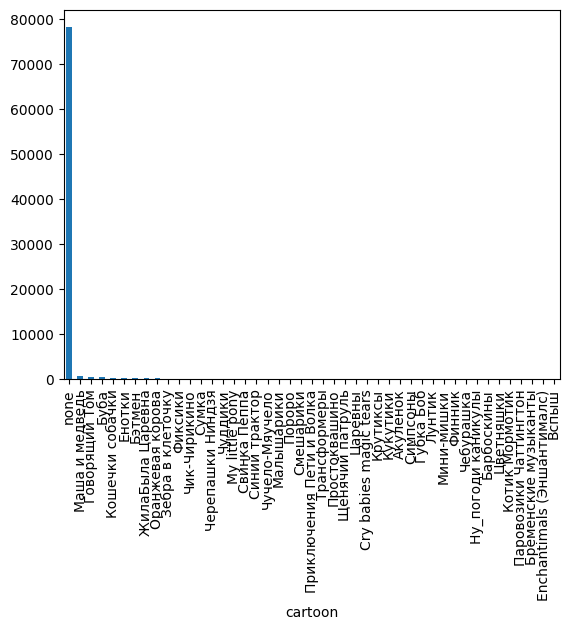

In [15]:
df['cartoon'].value_counts().plot(kind='bar')
plt.show()

**Вывод по текущему разделу.**
Датафрейм хранит информацию: 
- дата, когда ролик появился на ютубе
- название ролика
- уникальный идентификатор ролика на ютубе
- название проекта, целевая переменная
- ссылка на ролик (включает идентификатор)
- текст сниппета, включает название ролика и описание
- длительность
- вертикальные видеоролики продолжительностью <60сек
- лайвы, прямые эфиры
- идентификатор ютуб канала
- название ютуб канала
- ссылка на ютуб канал
- тип канала (Мультфильмы, Детские, Блогеры, Shorts…)
- ютуб канал закрыт, если 1
- метка международных каналов,
- каналов на иностранном языке (переведенный контент)
- язык  
Проведена проверка на дубликаты, пропуски. Дубликаты отсутствуют.  
Столбец cartoon используем в качестве целевого признака для задачи классификации. 
Целевой признак имеет выраженный дисбаланс.

## **2. Исследовательский анализ данных**

**2.1 Построим парную диаграмму признаков.**

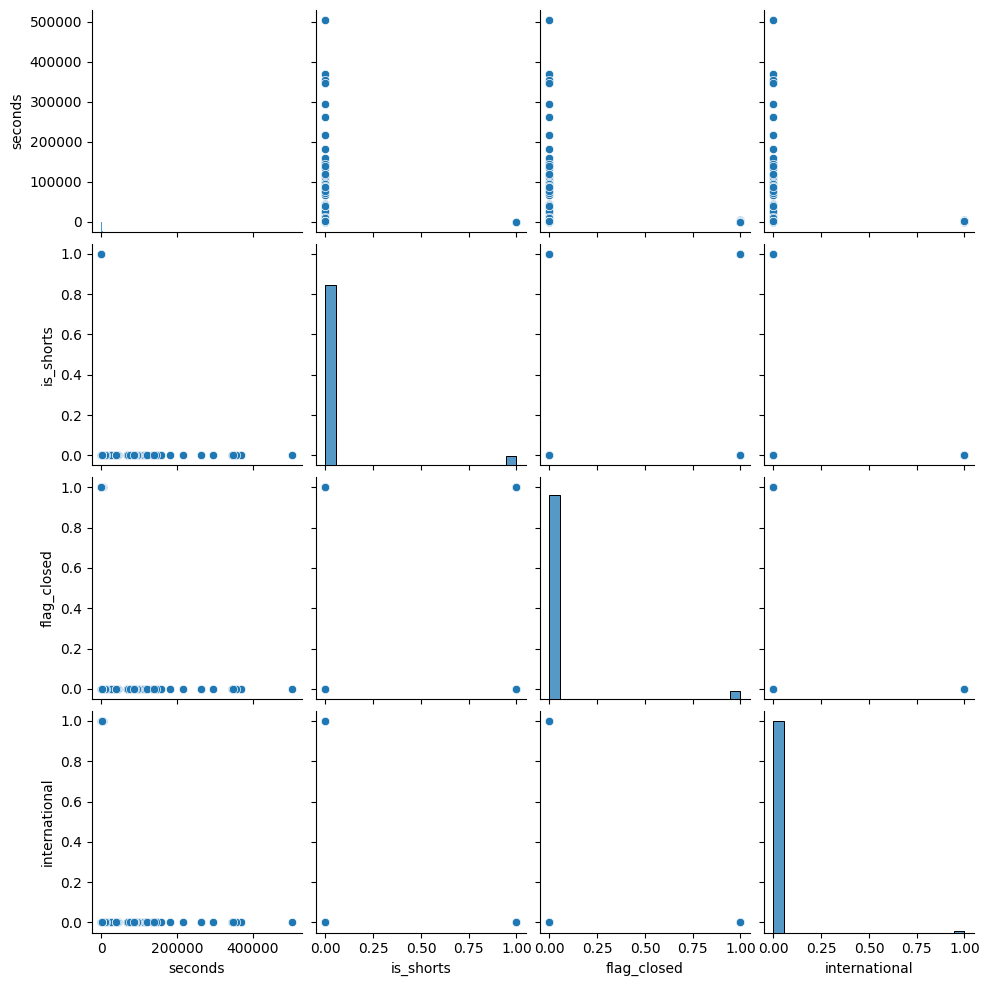

In [16]:
# парная диаграмма признаков
sn.pairplot(df)
plt.show()

**2.2 Построим общую гистограмму для всех числовых столбцов таблицы.**

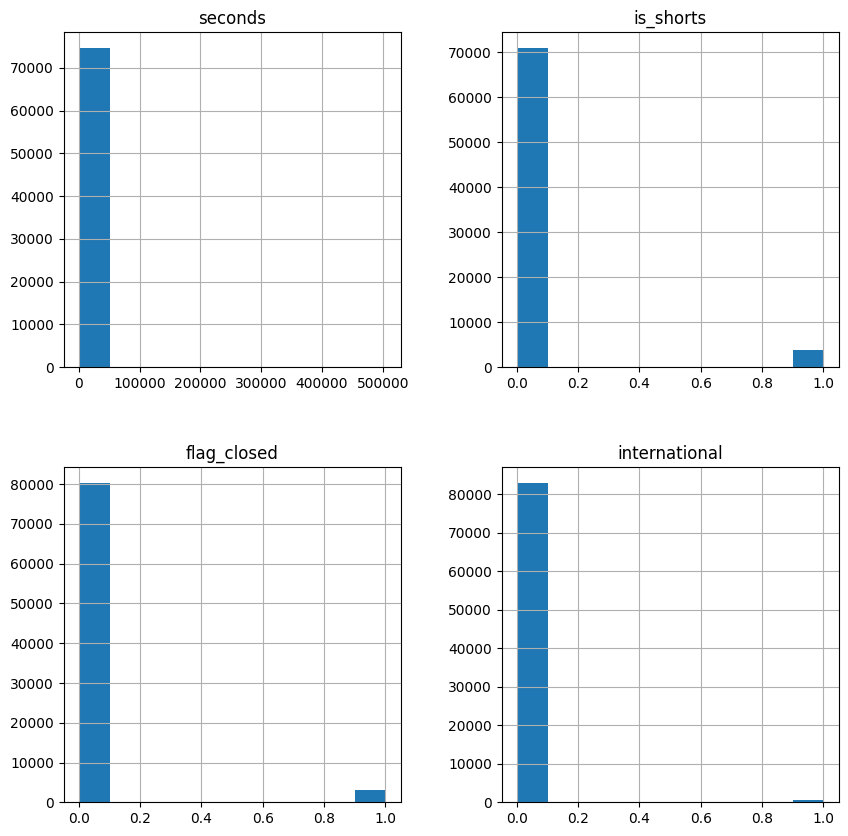

In [17]:
# построение общей гистограммы для всех числовых столбцов таблицы
df.hist(figsize=(10, 10))
# вызов метода show() для удаления технической строчки
plt.show()

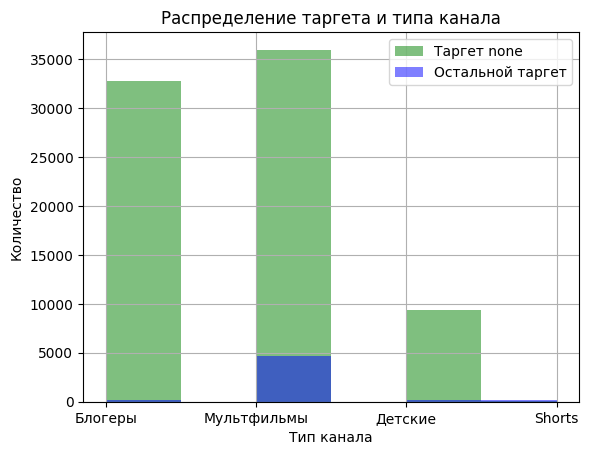

In [18]:
df[df['cartoon'] == 'none']['yt_channel_type'].hist(bins=6, alpha=0.5, color='green', label='Таргет none')
df[df['cartoon'] != 'none']['yt_channel_type'].hist(bins=6, alpha=0.5, color='blue', label='Остальной таргет')
plt.title('Распределение таргета и типа канала')
plt.xlabel('Тип канала')
plt.ylabel('Количество')
plt.legend()
plt.show()

Оценим взаимосвязь между числовыми признаками с помощью коэффициента корреляции. Используем график типа heatmap.

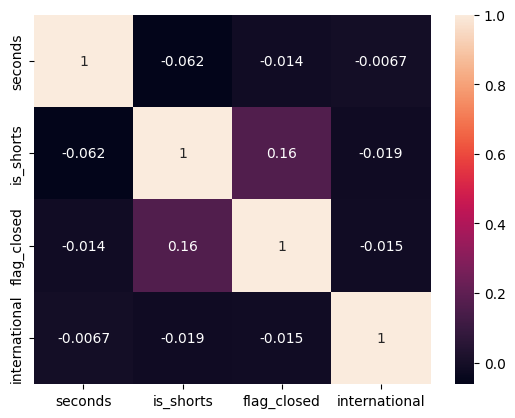

In [19]:
part_df = df[['seconds', 'is_shorts', 'flag_closed', 'international']]
part_df = pd.DataFrame(part_df)

corr_matrix = part_df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [20]:
# Объединяем два столбца вместе, создаем новый столбец Combined
df['Combined'] = df['reel_name'] + ' ' + df['yt_channel_name']

In [21]:
# загрузка данных в функцию препроцессинга
df['Combined'] = df['Combined'].apply(preprocess_text)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83360 entries, 0 to 83410
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83360 non-null  object 
 1   reel_name        83360 non-null  object 
 2   yt_reel_id       83360 non-null  object 
 3   cartoon          83360 non-null  object 
 4   url              83360 non-null  object 
 5   text             83360 non-null  object 
 6   seconds          74649 non-null  float64
 7   is_shorts        74649 non-null  float64
 8   broadcast        74649 non-null  object 
 9   yt_channel_id    83360 non-null  object 
 10  yt_channel_name  83360 non-null  object 
 11  yt_ch_url        83360 non-null  object 
 12  yt_channel_type  83360 non-null  object 
 13  flag_closed      83360 non-null  float64
 14  international    83360 non-null  float64
 15  language         497 non-null    object 
 16  Combined         83360 non-null  object 
dtypes: float64(4), ob

In [22]:
df['Combined']

0                               100 подарк остав miss katy
1        забага лиз реальн жизн артур наст follow me bo...
2        грозн семейк лучш сестринск момент хло фиб нор...
3                      сдела ожерел ткан сво рук трум трум
4        sleepover rules om nom stories cartoon for kid...
                               ...                        
83406    завтр ivi a hrefhttpswwwiviruwatchkorolevadvor...
83407                                прощ прост дракош тош
83408    добрын никитич зме горыныч фильм мультфильм бо...
83409    сен пап убега динозавр весел истор сен пап sup...
83410    live stream masha and the bear masha said that...
Name: Combined, Length: 83360, dtype: object

**Вывод по текущему разделу.**
- Построил общую гистограмму для всех числовых столбцов таблицы, а также парную гистограмму. 
Среди ушедших клиентов можно выделить следующие особенности:
- Оценил взаимосвязь между числовыми признаками с помощью коэффициента корреляции. Мультиколлинеарность отсутствует. 
- Создал новый столбец  Combined в котором объединил 2 признака reel_name и yt_channel_name
- Выполнил препроцессинг признака: 
    - приведение к нижнему регистру
    - очистка от специальных символов
    - удаление стоп слов
    - стемминг/токенизация

## **3. Обучение моделей**

**3.1 Разделим данные на признаки и целевой признак.**

In [23]:
features = df['Combined']
target=df['cartoon'] 
print(features)
print(target)

0                               100 подарк остав miss katy
1        забага лиз реальн жизн артур наст follow me bo...
2        грозн семейк лучш сестринск момент хло фиб нор...
3                      сдела ожерел ткан сво рук трум трум
4        sleepover rules om nom stories cartoon for kid...
                               ...                        
83406    завтр ivi a hrefhttpswwwiviruwatchkorolevadvor...
83407                                прощ прост дракош тош
83408    добрын никитич зме горыныч фильм мультфильм бо...
83409    сен пап убега динозавр весел истор сен пап sup...
83410    live stream masha and the bear masha said that...
Name: Combined, Length: 83360, dtype: object
0                  none
1                  none
2                  none
3                  none
4                  none
              ...      
83406              none
83407              none
83408              none
83409              none
83410    Маша и медведь
Name: cartoon, Length: 83360, dtype: objec

**3.2. Разделим исходные данные на обучающую (75%) и валидационную (25%) выборки.**

In [24]:
# обучающая и валидационная 75% и 25%
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target,
                                                                              test_size=0.25,
                                                                              stratify = target,
                                                                              random_state=12345)

In [25]:
# проверим размер выборок
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape

((62520,), (62520,), (20840,), (20840,))

In [26]:
print(features_train)

3766     челлендж квест найд лол сюрприз снег кукл lol ...
25694    мультик машинк игрушк плеймоб год тренировок м...
78730    ks kids развива игрушк малыш 0 лет игрушк gull...
28801                    shorts dc kids international бэтм
73098             альбомгармошк фотограф сво рук трум трум
                               ...                        
34465    распаковк 15 сюрприз открыва собира нов коллек...
36219                 откуд взял кукл lol vania mania kids
6791     урок 30 нов годонлайн школ русск язык помощ ин...
11013          мультфильм огон мультик студ союзмультфильм
77789    tour pela comidinhas da minha geladeira bush b...
Name: Combined, Length: 62520, dtype: object


In [27]:
print(target_valid)

50275    none
43876    none
39743    none
77138    none
53367    none
         ... 
64507    none
27186    none
42252    none
11030    none
79706    none
Name: cartoon, Length: 20840, dtype: object


In [28]:
tf_idf = TfidfVectorizer()
#выполним векторизацию признаков с помощью TF-IDF: TfidfVectorizer
tfidf_train = tf_idf.fit_transform(features_train)
tfidf_valid = tf_idf.transform(features_valid)


In [29]:
print(tfidf_train)
print(tfidf_valid)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 561488 stored elements and shape (62520, 27527)>
  Coords	Values
  (0, 26629)	0.21370035197315185
  (0, 15270)	0.36357565270753284
  (0, 18237)	0.35097241905242127
  (0, 16738)	0.3291594153205211
  (0, 24572)	0.22344814656165646
  (0, 23672)	0.3422722016012474
  (0, 16272)	0.25468011477035435
  (0, 5284)	0.3451884454453176
  (0, 2105)	0.26732702338318315
  (0, 5961)	0.2402535284639481
  (0, 5257)	0.23306786222074202
  (0, 6028)	0.23667459307147748
  (1, 17955)	0.13333362946767321
  (1, 17288)	0.1835793280910631
  (1, 14654)	0.2038467783567317
  (1, 20308)	0.38567376928838965
  (1, 12482)	0.2778565656129435
  (1, 25156)	0.5314623072499801
  (1, 17880)	0.5314623072499801
  (1, 21339)	0.22484576792549668
  (1, 14649)	0.2560444291991289
  (2, 14654)	0.4874405270498158
  (2, 5017)	0.596614270427799
  (2, 4851)	0.17081677769869905
  (2, 21974)	0.24163399215677145
  :	:
  (62517, 22653)	0.3025237205013679
  (62517, 559)	0.245148991

**3.3. Исследуем качество разных моделей: LinearRegression, RandomForestClassifier, LGBMRegression, KNeighborsClassifier, GradientBoostingClassifier.**

**4.3.1 Логистическая регрессия** 

In [35]:
%%time
model_LogisticRegression = LogisticRegression(random_state = 12345, class_weight='balanced')
model_LogisticRegression.fit(tfidf_train, target_train)
predictions = model_LogisticRegression.predict(tfidf_valid)
print("f1_score: ", f1_score(target_valid, predictions, average='weighted'))

f1_score:  0.967321045069397
CPU times: total: 50.6 s
Wall time: 30 s


In [36]:
%%time
grid={'model': [LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')],
           'model__C':[.01,.05,.1,.5,1,5,10,20,50,100,200,300,400,500],
           'model__penalty':['l1','l2']}
pipeline = Pipeline([('model',LogisticRegression())])
grid_LR = GridSearchCV(pipeline, cv=3, verbose=3, n_jobs=-1, param_grid=grid ,scoring='f1_weighted')
best_grid = grid_LR.fit(tfidf_train, target_train)
print('Лучшие параметры:', grid_LR.best_params_)
print('Лучшее значение F1:', grid_LR.best_score_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Лучшие параметры: {'model': LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear'), 'model__C': 100, 'model__penalty': 'l1'}
Лучшее значение F1: 0.9963732392219394
CPU times: total: 39.8 s
Wall time: 12min 59s


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**3.3.2 Случайный лес**

In [37]:
%%time
best_result = 0
best_est = 0
best_depth = 0
for est in [1, 5, 20, 50, 81]:
    for depth in [1, 5, 10, 20, 50, 81]:
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(tfidf_train, target_train)
        predictions_train = model.predict(tfidf_valid)
        f1 = f1_score(target_valid, predictions_train, average='weighted')
        print('Количество деревьев:', est, 'Глубина:', depth)
        print("F1 для RandomForestClassifier:", f1)
        if f1 > best_result:
            best_result = f1 #  сохраните наилучшее значение метрики accuracyf1 на валидационных данных
print()
print("F1 для RandomForestClassifier:", best_result)

Количество деревьев: 1 Глубина: 1
F1 для RandomForestClassifier: 0.008897514597023327
Количество деревьев: 1 Глубина: 5
F1 для RandomForestClassifier: 0.012204467975153975
Количество деревьев: 1 Глубина: 10
F1 для RandomForestClassifier: 0.02478493322830581
Количество деревьев: 1 Глубина: 20
F1 для RandomForestClassifier: 0.036890784086620595
Количество деревьев: 1 Глубина: 50
F1 для RandomForestClassifier: 0.2138038189612158
Количество деревьев: 1 Глубина: 81
F1 для RandomForestClassifier: 0.3775054709414329
Количество деревьев: 5 Глубина: 1
F1 для RandomForestClassifier: 0.008916134718283219
Количество деревьев: 5 Глубина: 5
F1 для RandomForestClassifier: 0.03643132822198704
Количество деревьев: 5 Глубина: 10
F1 для RandomForestClassifier: 0.059086285198109545
Количество деревьев: 5 Глубина: 20
F1 для RandomForestClassifier: 0.16417340695804253
Количество деревьев: 5 Глубина: 50
F1 для RandomForestClassifier: 0.5296797746021336
Количество деревьев: 5 Глубина: 81
F1 для RandomForestCl

In [38]:
%%time
#model_RandomForestClassifier = RandomForestClassifier(random_state=12345, class_weight='balanced')
#parametrs = { 'n_estimators': [90, 100],
#              'max_depth': [90, 100]}
#grid_RF = GridSearchCV(model_RandomForestClassifier, parametrs, scoring='f1_weighted', cv=5)
#grid_RF.fit(tfidf_train, target_train)
#grid_RF = grid_RF.fit(tfidf_train, target_train)
#print('Лучшие параметры:', grid_RF.best_params_)#print('Лучшее значение F1:', grid_RF.best_score_)

CPU times: total: 0 ns
Wall time: 0 ns


**3.3.3 Модель градиентного бустинга LGBMClassifier.**

In [39]:
%%time
# проверим модель без гиперпараметров
model_LGBM = lgb.LGBMClassifier(random_state=12345, class_weight='balanced')
model_LGBM.fit(tfidf_train, target_train)
predictions_test = model_LGBM.predict(tfidf_valid)
f1_best_LightGBM = f1_score(target_valid, predictions_test, average='weighted')
print("F1 для LGBMClassifier:", f1_best_LightGBM)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.370580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118718
[LightGBM] [Info] Number of data points in the train set: 62520, number of used features: 2826
[LightGBM] [Info] Start training from score -3.806663
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.80

**3.3.4 Модель KNN (ближайших соседей).**

In [40]:
%%time
# Обучение модели KNN
model = KNeighborsClassifier(n_neighbors=5)  # Выберите количество соседей
model.fit(tfidf_train, target_train)

y_pred = model.predict(tfidf_valid)
print("f1_score: ", f1_score(target_valid, y_pred, average='weighted'))
print(classification_report(target_valid, y_pred))


f1_score:  0.9925455998958926


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                            precision    recall  f1-score   support

    Cry babies magic tears       1.00      1.00      1.00         5
Enchantimals (Эншантималс)       0.00      0.00      0.00         1
            My little pony       0.93      0.65      0.76        20
                      none       1.00      1.00      1.00     19547
                  Акуленок       0.00      0.00      0.00         3
                Барбоскины       0.33      0.50      0.40         2
      Бременские музыканты       1.00      1.00      1.00         2
                      Буба       0.92      0.96      0.94       132
                    Бэтмен       0.99      0.89      0.93        88
                     Вспыш       0.00      0.00      0.00         1
             Говорящий Том       0.99      0.99      0.99       146
                 Губка Боб       0.00      0.00      0.00         3
                    Енотки       0.97      0.99      0.98        95
          ЖилаБыла Царевна       0.91      0.86

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**3.3.5 Модель градиентного бустинга.**

In [41]:
%%time
# Бустинг
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=12345)
gb_model.fit(tfidf_train, target_train)
# Прогнозирование
y_pred_gb = gb_model.predict(tfidf_valid)
print("f1_score: ", f1_score(target_valid, y_pred_gb, average='weighted'))

f1_score:  0.9128378941250667
CPU times: total: 22min 43s
Wall time: 22min 56s


In [46]:
table_data = [["LinearRegression:", grid_LR.best_score_],
             ["RandomForestClassifier:", best_result],
             ["LGBMClassifier:", f1_best_LightGBM],
             ["KNeighborsClassifier:", f1_score(target_valid, y_pred, average='weighted')],
             ["GradientBoostingClassifier:", f1_score(target_valid, y_pred_gb, average='weighted')]]

df_result= pd.DataFrame(table_data, columns=["model", "F1"])
df_result = df_result.set_index('model')
df_result.index.names = [None]
df_result

,F1
LinearRegression:,0.996373
RandomForestClassifier:,0.989540
LGBMClassifier:,0.994527
KNeighborsClassifier:,0.992546
GradientBoostingClassifier:,0.912838


**Вывод по текущему разделу.**

- Выделили из датасета признаки и целевой признак.
- Разделили данные на обучающую и тестовую выборки. 
- Выполнили балансировку классов class_weight='balanced'
- Исследовали качество разных моделей: LinearRegression, RandomForestClassifier, LGBMRegression, KNeighborsClassifier, GradientBoostingClassifier.
- Выполнили проверка адекватности модели.

Лучшее значение метрики F1 у модели LinearRegression.

## Тестирование модели

In [31]:
#df_test = pd.read_csv('D:/YandexDisk/ЯП/Союзмультфильм/датасет/test.csv', lineterminator = '\n')
df_test = pd.read_csv('C:/Users/User/YandexDisk/ЯП/Союзмультфильм/датасет/test.csv', lineterminator = '\n')

df_test.head()

,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2020-10-26,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,https://youtube.com/channel/UCfeljpDR__qqp-lLB...,Детские,0.0,0.0,NaN
1,2024-03-24,Tractor mini Bulldozer to making concrete road...,5wTfpmlZe5k,https://www.youtube.com/watch?v=5wTfpmlZe5k,[Tractor mini Bulldozer to making concrete roa...,0.0,0.0,live,UCIDMp2rLX4G5C6eiypl9SFA,OneDayAlex,https://www.youtube.com/channel/UCIDMp2rLX4G5C...,Блогеры,0.0,0.0,NaN
2,2020-06-28,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлендж,Fd9YA-oDjSo,https://www.youtube.com/watch?v=Fd9YA-oDjSo,[Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челле...,1599.0,0.0,none,UC2tsySbe9TNrI-xh2lximHA,A4,https://youtube.com/channel/UC2tsySbe9TNrI-xh2...,Блогеры,0.0,0.0,NaN
3,2018-07-27,Мультики про машинки и паровозики для детей. Р...,NXCHY_J-5v0,https://www.youtube.com/watch?v=NXCHY_J-5v0,[Мультики про машинки и паровозики для детей. ...,467.0,0.0,none,UC_J_9-qRfVtKIkq7SxxVbhQ,ТВ Деткам,https://youtube.com/channel/UC_J_9-qRfVtKIkq7S...,Детские,0.0,0.0,NaN
4,2021-04-03,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,XM-GRekoYzs,https://www.youtube.com/watch?v=XM-GRekoYzs,[СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТО...,364.0,0.0,none,UCSmqZkD74x3TLt6eRM5GhTg,Dargas,https://youtube.com/channel/UCSmqZkD74x3TLt6eR...,Блогеры,0.0,0.0,NaN


In [32]:
df_test['reel_name'] = df_test['reel_name'].fillna('unknown')
df_test['yt_channel_name'] = df_test['yt_channel_name'].fillna('unknown')
df_test['Combined'] = df_test['reel_name'] + ' ' + df_test['yt_channel_name']


In [33]:
# загрузка данных в функцию препроцессинга
df_test['Combined'] = df_test['Combined'].apply(preprocess_text)

In [34]:
#выполним векторизацию признаков с помощью TF-IDF: TfidfVectorizer
tfidf_test = tf_idf.transform(df_test['Combined'])
print(tfidf_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 486758 stored elements and shape (55608, 27527)>
  Coords	Values
  (0, 4851)	0.26628061390000335
  (0, 7467)	0.4589399880429698
  (0, 8889)	0.3155322607428835
  (0, 13082)	0.11456466431019989
  (0, 13134)	0.18634529506531583
  (0, 17043)	0.20680635908691256
  (0, 17786)	0.2753358760097275
  (0, 20024)	0.18073270460067492
  (0, 20051)	0.19615121081532647
  (0, 21054)	0.3200103054190448
  (0, 21898)	0.31050984909294316
  (0, 22414)	0.3151776227844573
  (0, 26443)	0.2884098897568455
  (1, 1888)	0.2964602184114687
  (1, 2407)	0.24089999110168267
  (1, 2430)	0.23971907070145043
  (1, 5413)	0.32648431177573983
  (1, 5702)	0.291880639615489
  (1, 6333)	0.1969352583194741
  (1, 7341)	0.5544004320004537
  (1, 7389)	0.3491966616232021
  (1, 8673)	0.17849745754757892
  (1, 8757)	0.21010347588063774
  (1, 9069)	0.24645593992056428
  (2, 900)	0.30343803199935593
  :	:
  (55604, 22582)	0.1260392457968157
  (55604, 27032)	0.223983232590562

In [47]:
predictions = grid_LR.predict(tfidf_test)
predictions[:10]

array(['none', 'none', 'none', 'none', 'none', 'Чуддики', 'none', 'none',
       'none', 'none'], dtype=object)

In [48]:
# первая пара ключа и значения - это id, вторая - прогноз "на тесте"
result = pd.DataFrame({'yt_reel_id': df_test['yt_reel_id'], 'cartoon': predictions})
result.head(20)

,yt_reel_id,cartoon
0,RBw4j0aMWyM,none
1,5wTfpmlZe5k,none
2,Fd9YA-oDjSo,none
3,NXCHY_J-5v0,none
4,XM-GRekoYzs,none
5,LACMWI1pqdw,Чуддики
6,7HPiAOD9P3o,none
7,3-r4M9QJuLA,none
8,0mM01aIacko,none
9,6d4qSrL2hMc,none


In [50]:
# создадим новый файл result.csv с помощью функции to_csv(), удалив при этом индекс
result.to_csv('C:/Users/User/YandexDisk/ЯП/Союзмультфильм/датасет/_submission/base2/submission_final.csv', index = False)